# Habitability Score of House Predictions
*(Part 2 - Model Evaulation)*

In [1]:
# To ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

# Import required libraries
import pandas as pd
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# for model building
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# for model evaluation
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
# Read CSV files
def readCSV(x, y):
    X = pd.read_csv(f'{x}.csv')
    y = pd.read_csv(f'{y}.csv')['habitability_score']
    return X, y

# Read training data
X, y = readCSV('X', 'y')

# Read test data
X_test, y_test = readCSV('X_test', 'y_test')

### Model Selection

- Baseline Model - Linear Regression

In [3]:
def score(y_true, y_pred):
    return max(0, 100*(r2_score(y_true, y_pred)))

def fit_and_evaluate(model):
    # Train a model
    model.fit(X, y)
    
    # Make predictions and evaluate
    predictions = model.predict(X)
    model_score = score(y, predictions)
    
    # Returns the evaluation metrics
    return model_score

In [4]:
baseline_model = LinearRegression()
baseline_score = fit_and_evaluate(baseline_model)
print(f"Baseline model R2 Score:: {baseline_score:.2f}")

Baseline model R2 Score:: 56.64


#### Select & Train a model

Train and evaluate multiple models on training data.

- Random Forest Regression
- Gradient Boosting Regression
- Support Vector Machine Regression
- K-nearest neighbors Regression
- XGBRegressor

In [5]:
models = {
    'rf': RandomForestRegressor(random_state=42),
    'gb': GradientBoostingRegressor(random_state=42),
    'svr': SVR(),
    'knn': KNeighborsRegressor(),
    'xgb': XGBRegressor(random_state=42)
}
model_scores = []

for name, model in models.items():
    model_score = fit_and_evaluate(model)
    model_scores.append((name, model_score))
    print(f"{name} score: {model_score}")

rf score: 97.91871976400664
gb score: 80.90934191039109
svr score: 86.62266495396189
knn score: 83.01877879046506
xgb score: 90.9318813179696


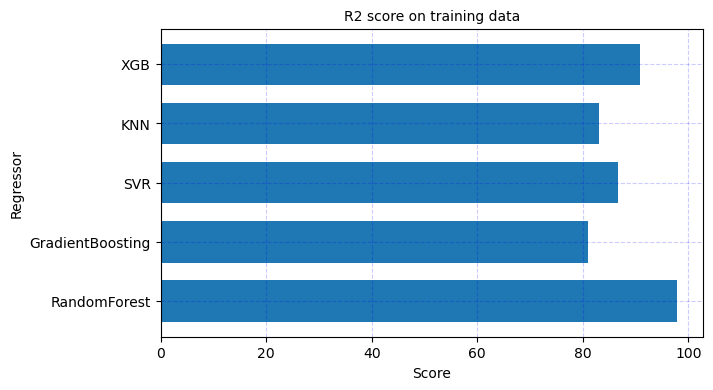

In [6]:
models = ['RandomForest', 'GradientBoosting', 'SVR', 'KNN', 'XGB']
model_performance_df = pd.DataFrame(data=model_scores, columns=['models', 'score'], index=models)

# plot
plt.figure(figsize=(7, 4))
model_performance_df['score'].plot(kind='barh', width=0.7)

plt.title("R2 score on training data", size=10)
plt.xlabel("Score", size=10)
plt.ylabel("Regressor", size=10)

plt.grid(ls="--", c='b', alpha=0.2)
plt.show()

We can see that the `RandomForestRegressor` perform better and returns highest score than other machine learning models and return almost 98% of accuracy on training data.

#### Cross-validation
We can't use test data until final selection of a model. So, for better valuation of model, Let's evaluate the model performance using Scikit-Learn's K-fold cross-validation feature.

- The following code randomly splits the training dataset into 10 distinct subsets.
- Then train and evaluate the model 10 times, and return average score.

In [7]:
# Cross Validation
from sklearn.model_selection import cross_val_score

def cv_score(scores):
    mean = max(0, 100*(scores.mean()))
    std = max(0, 100*(scores.std()))
    return mean, std


models = {
    'lr': LinearRegression(),
    'rf': RandomForestRegressor(random_state=42),
    'gb': GradientBoostingRegressor(random_state=42),
    'svr': SVR(),
    'knn': KNeighborsRegressor(),
    'xgb': XGBRegressor(random_state=42)
}

model_scores = []
for name, model in models.items():
    scores = cross_val_score(model, 
                             X, 
                             y,
                             scoring='r2',
                             cv=10)
    mean, std = cv_score(scores)
    model_scores.append((name, round(mean, 2), round(std, 2)))
    print(f"{name} r2-score:: {mean:.2f} +-{std:.2f}")

lr r2-score:: 56.36 +-1.72
rf r2-score:: 84.93 +-0.87
gb r2-score:: 79.98 +-0.83
svr r2-score:: 82.67 +-0.87
knn r2-score:: 73.08 +-1.82
xgb r2-score:: 83.83 +-0.75


Overall model performance scores drop but top 3 models  `RandomForestRegressor`,  `XGBRegressor` and `SVR` have a very little difference in their scores. 

For now, Let's try to improve performance of the random forest algorithm which gives the highest r2 score of 84.94 with 0.88 standard deviation by tunning hyperparameter using searching algorithm.

### Model Optimization
Using Scikit-learn searching algorithms - RandomSearchCV, GridSearchCV.

In [8]:
# Set up a Randomized search CV for 5-fold cross validation
from sklearn.model_selection import RandomizedSearchCV

def searchCV(model, parameterGrid):
    
    random_cv = RandomizedSearchCV(estimator = model,
                                   param_distributions = parameterGrid,
                                   n_iter = 25, 
                                   cv = 5,
                                   scoring ='r2',
                                   verbose = 1, 
                                   random_state = 42,
                                   return_train_score = True)
    # Fit on the training data
    random_cv.fit(X, y)
    return random_cv

- Random Forest Regressor

In [9]:
# Number of trees
n_estimators = [100, 200, 500, 800, 1000]

# depth of the trees
max_depth = [3, 5, 7, 9]

# Minimum number of samples at splits
min_samples_split = [10, 100, 1000]

# Minimum number of sample at leaf
min_samples_leaf = [1, 10, 100]

# Hyperparameter grid
hyperparameter_grid = {
    'n_estimators' : n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
}

# define a model for hyperparameter tunning
model = RandomForestRegressor(max_features='sqrt', n_jobs=-1, random_state=42)

random_cv = searchCV(model, hyperparameter_grid)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [10]:
pd.DataFrame(random_cv.cv_results_).sort_values(by=['mean_test_score'], ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
2,7.422412,0.159021,0.399455,0.033237,800,10,10,9,"{'n_estimators': 800, 'min_samples_split': 10,...",0.788821,...,0.790309,0.004431,1,0.806727,0.809098,0.806663,0.806837,0.807718,0.807409,0.000927
22,7.149554,0.148194,0.432724,0.100503,800,100,1,9,"{'n_estimators': 800, 'min_samples_split': 100...",0.772080,...,0.772764,0.004162,2,0.785405,0.786057,0.783523,0.784834,0.786056,0.785175,0.000943
13,4.704004,0.095491,0.257447,0.007212,500,100,1,9,"{'n_estimators': 500, 'min_samples_split': 100...",0.771831,...,0.772382,0.003762,3,0.785145,0.785401,0.783123,0.783561,0.786279,0.784702,0.001180
11,9.348293,0.113242,0.518251,0.020822,1000,100,10,9,"{'n_estimators': 1000, 'min_samples_split': 10...",0.770286,...,0.771207,0.004438,4,0.782535,0.784048,0.781801,0.781495,0.783716,0.782719,0.001013
10,6.429294,0.103112,0.417455,0.062765,800,10,1,7,"{'n_estimators': 800, 'min_samples_split': 10,...",0.744060,...,0.747486,0.004939,5,0.760251,0.763603,0.761138,0.761608,0.761734,0.761667,0.001099


In [11]:
random_cv.best_estimator_

RandomForestRegressor(max_depth=9, max_features='sqrt', min_samples_leaf=10,
                      min_samples_split=10, n_estimators=800, n_jobs=-1,
                      random_state=42)

In [12]:
best_model = random_cv.best_estimator_
scores = cross_val_score(best_model, 
                         X, 
                         y,
                         scoring='r2',
                         cv=10)
mean, std = cv_score(scores)
print(f"Best model score:: {mean:.2f} +- {std:.2f}")

Best model score:: 79.15 +- 0.95


Unfortunately, the best model after hyperparameter tunning is less accurate than model with default parameter settings. 

Let's examine the model performance of `RandomForestRegressor` by keeping all other hyperparameters value and varing single parameter value and that is `n_estimators`. 

We will use grid search with grid that only has `n_estimators` hyperparamter. we will evaluate a range of trees then plot the training and testing performance to get an idea of what increasing number of trees does for our model.

In [13]:
# Create a range of trees to evaluate
from sklearn.model_selection import GridSearchCV

tree_grid = {'n_estimators' : list(range(100, 1250, 50))}

model = RandomForestRegressor(max_depth=9,
                              max_features='sqrt',
                              min_samples_split=10,
                              n_jobs=-1, 
                              random_state=42)

# Grid Search object using tree range and random forest model.
grid_search = GridSearchCV(
    estimator = model,
    param_grid = tree_grid,
    cv = 5, 
    scoring = 'r2',
    verbose = 1,
    n_jobs = -1,
    return_train_score = True)

In [14]:
# Fit the grid search on training data
grid_search.fit(X, y)

Fitting 5 folds for each of 23 candidates, totalling 115 fits


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=9, max_features='sqrt',
                                             min_samples_split=10, n_jobs=-1,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400,
                                          450, 500, 550, 600, 650, 700, 750,
                                          800, 850, 900, 950, 1000, 1050, 1100,
                                          1150, 1200]},
             return_train_score=True, scoring='r2', verbose=1)

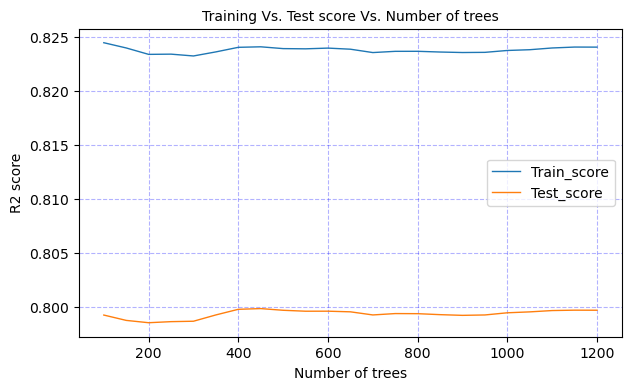

In [15]:
# Get the results into dataframe
results = pd.DataFrame(grid_search.cv_results_)

# plot the results
plt.figure(figsize=(7, 4))

sns.lineplot(data=results, x='param_n_estimators', y=results['mean_train_score'], lw=1, label='Train_score')
sns.lineplot(data=results, x='param_n_estimators', y=results['mean_test_score'], lw=1, label='Test_score')

plt.xlabel("Number of trees", size=10)
plt.ylabel("R2 score", size=10)
plt.title("Training Vs. Test score Vs. Number of trees", size=10)

plt.grid(ls="--", c='b', alpha=0.3)
plt.show()

From this plot, it's pretty clear that our model is overfitting! The training score is greater than the testing score, which shows that the model is learning the training data very well but then unable to generalize to the test data. 

We can see almost constant difference in training and testing score as number of trees increases. There will always be a difference between the training and testing scores (The training accuracy is always high) but if there is a significant difference, we want to try and reduce the overfitting, either by getting more training data or reducing the complexity of the model through hyperparameter tunning or regularization. 

For the random forest regressor, some options include reducing the number of trees, reducing the max depth of each tree, and increasing the minimum number of samples in a leaf node. For now, we will use the model with the best performance and accept that it may be overfitting to the training set.

Based on the cross validation results, the best model using 450 trees can achieves a r2 score of appx 80. 

- XGBRegressor

In [16]:
# Hyperparameter grid
hyperparameter_grid = {
    'n_estimators' : list(range(100, 1200, 100)),
    'max_depth': [3, 5, 7, 9],
    'learning_rate': np.linspace(0.01, 0.10, 10)
}

# define a model for hyperparameter tunning
xg_model = XGBRegressor(subsample=0.8, n_jobs=-1, random_state=42)
xg_random_cv = searchCV(xg_model, hyperparameter_grid)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [17]:
pd.DataFrame(xg_random_cv.cv_results_).sort_values(by=['mean_test_score'], ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
7,31.507352,0.958232,0.122755,0.013507,600,9,0.02,"{'n_estimators': 600, 'max_depth': 9, 'learnin...",0.855250,0.851627,...,0.852520,0.002646,1,0.941269,0.942150,0.940641,0.941498,0.940542,0.941220,0.000590
18,32.095659,1.256006,0.107141,0.007264,800,7,0.02,"{'n_estimators': 800, 'max_depth': 7, 'learnin...",0.851714,0.848978,...,0.849581,0.002611,2,0.918530,0.919521,0.918360,0.918945,0.918358,0.918743,0.000444
11,38.824303,0.494045,0.128463,0.006212,1000,7,0.02,"{'n_estimators': 1000, 'max_depth': 7, 'learni...",0.851151,0.848957,...,0.849413,0.002550,3,0.927909,0.928548,0.927696,0.928416,0.928042,0.928122,0.000317
15,42.738189,1.249072,0.176871,0.069932,1100,7,0.02,"{'n_estimators': 1100, 'max_depth': 7, 'learni...",0.850850,0.848771,...,0.849184,0.002578,4,0.932051,0.932636,0.931693,0.932260,0.932220,0.932172,0.000307
3,16.864197,0.264541,0.061558,0.006683,300,9,0.06,"{'n_estimators': 300, 'max_depth': 9, 'learnin...",0.850568,0.847730,...,0.849070,0.001885,5,0.961358,0.961178,0.959342,0.960283,0.959384,0.960309,0.000854


In [18]:
xg_best_model = xg_random_cv.best_estimator_
scores = cross_val_score(best_model, 
                         X, 
                         y,
                         scoring='r2',
                         cv=10)
mean, std = cv_score(scores)
print(f"Best model score:: {mean:.2f} +- {std:.2f}")

Best model score:: 79.15 +- 0.95


In [23]:
import pickle
output_file = 'search_cv.bin'
with open(output_file, 'wb') as f:
    pickle.dump((random_cv, grid_search, xg_random_cv), f)

xg_best_model = xg_random_cv.best_estimator_
with open('xg_model.bin', 'wb') as f:
    pickle.dump(xg_best_model, f)

### Evaluate Final Model on the Test Set.


In [30]:
# default model
default_model = XGBRegressor(random_state=42)

# select the best model
final_model = xg_random_cv.best_estimator_
final_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.020000000000000004,
             max_delta_step=0, max_depth=9, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=600, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

3.67 s ± 156 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [24]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

4.97 s ± 115 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [32]:
# make predictions
default_preds = default_model.predict(X_test)
final_preds = final_model.predict(X_test)

print("Default model performance on test data:: %.3f" %max(0, 100*(r2_score(y_test, default_preds))))
print("Final model performance on test data:: %.3f" %max(0, 100*(r2_score(y_test, final_preds))))

Default model performance on test data:: 82.872
Final model performance on test data:: 84.483


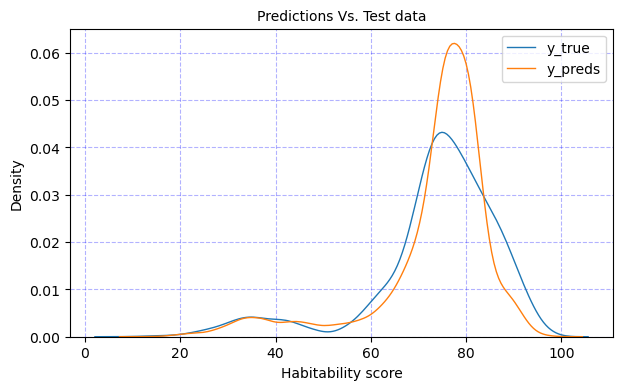

In [33]:
# Density plot for final predictions and test data
plt.figure(figsize=(7, 4))

sns.kdeplot(np.expm1(y_test), lw=1, label='y_true')
sns.kdeplot(np.expm1(final_preds), lw=1, label='y_preds')

plt.xlabel("Habitability score", size=10)
plt.title("Predictions Vs. Test data", size=10)

plt.legend()
plt.grid(ls='--', c='b', alpha=0.3)
plt.show()

The distribution looks to be nearly the same. Another diagonostic plot is a histogram of the residuals, ideally, we would hope that the residual are normally distributed meaning that the model is wrong the same amount in both direction (high and low).

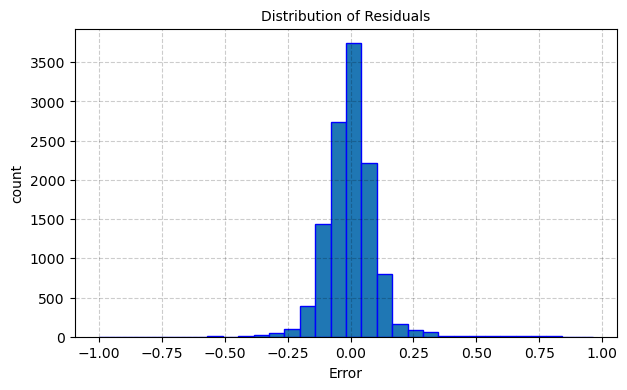

In [36]:
plt.figure(figsize=(7, 4))

# Calculate the residuals
residuals = final_preds - y_test

# Plot the residuals in a histogram
plt.hist(residuals, bins=32, edgecolor='b')

plt.xlabel('Error')
plt.ylabel('count')
plt.title('Distribution of Residuals', size=10)

plt.grid(c='#000', ls='--', alpha=0.2)
plt.show()

The residuals are normally distributed with a few noticeable outliers on the both ends. This indicate errors where the model estimate was far below or above that of the true value.